In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=8b03f637bec02502427aa5a145bf4d260d5c9e7a6570c8c869a1c7ee64623a98
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [4]:
import yfinance as yf
import ta
import pandas as pd

# تنظیمات
ticker = 'AAPL'  # Example: Apple Inc.
start_date = "2000-10-12"
end_date = "2024-01-01"
analysis_start_date = "2023-01-03"  # تاریخ شروع مورد نظر

# دانلود داده‌های سهام از Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
data = data.resample('1D').ffill()


# محاسبه میانگین‌های متحرک و اندیکاتورهای تکنیکال
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()




# تنظیم DataFrame نهایی
df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# نمایش داده‌ها
df


[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2000-10-12,0.357143,1191064000,NaN,NaN,NaN,NaN
2000-10-13,0.393973,1247752800,NaN,NaN,NaN,NaN
2000-10-14,0.393973,1247752800,NaN,NaN,NaN,NaN
2000-10-15,0.393973,1247752800,NaN,NaN,NaN,NaN
2000-10-16,0.383929,820176000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-25,193.600006,37122800,195.188004,191.248201,50.022824,194.581887
2023-12-26,193.050003,28919300,194.736003,191.524601,47.619812,194.303362
2023-12-27,193.149994,48087700,194.294002,191.751201,48.107867,194.093659


In [5]:
def get_batched_data_fn(context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(num_examples):
            yield {k: v[i] for k, v in examples.items()}

    return data_fn

In [6]:
import timesfm

context_len = 512
batch_size = 1  # ثابت نگه‌داشتن batch size
horizon_len = 1  # ثابت نگه‌داشتن horizon length



In [7]:

    model = timesfm.TimesFm(
        context_len=context_len,
        horizon_len=horizon_len,
        input_patch_len=32,
        output_patch_len=128,
        num_layers=20,
        model_dims=1280,
        backend="gpu",
    )
    model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.51 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.38 seconds.
Jitting decoding.
Jitted decoding in 23.32 seconds.


In [33]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

# Define context lengths to test
context_lengths = range(64, 513, 32)

# Define the start date and number of days to predict
analysis_start_date = pd.to_datetime("2023-03-08")

# Store results for different context lengths
results_by_context_len = []

for context_len in context_lengths:
    print(f"Processing context_len: {context_len}")

    # تنظیم داده‌ها
    start_idx = df.index.get_loc(analysis_start_date) - context_len

    # حلقه پیش‌بینی تا پایان داده‌ها
    while start_idx + context_len < len(df):
        # تعیین بازه زمانی بر اساس context_len
        end_idx = start_idx + context_len

        inputs = df['close'].iloc[start_idx:end_idx].tolist()

        # Prepare dynamic numerical covariates, e.g., volume
        dynamic_numerical_covariates = {
            "volume": df['volume'].iloc[start_idx:end_idx].tolist() + [df['volume'].iloc[end_idx-1]],
        }
        dynamic_numerical_covariates_formatted = {k: [v] for k, v in dynamic_numerical_covariates.items()}

        # Make the forecast using the model
        raw_forecast, _ = model.forecast(
            inputs=[inputs], freq=[0] * len(inputs)
        )

        # Make the forecast with covariates using the model
        cov_forecast, ols_forecast = model.forecast_with_covariates(
            inputs=[inputs],
            dynamic_numerical_covariates=dynamic_numerical_covariates_formatted,
            dynamic_categorical_covariates={},
            static_numerical_covariates={},
            static_categorical_covariates={},
            freq=[0] * len(inputs),
            normalize_xreg_target_per_input=True,
            xreg_mode="xreg + timesfm",
        )

        # Store the prediction date and actual values
        predict_date = df.index[end_idx]
        y_actual = df['close'].iloc[end_idx]

        # Append results to the list
        results_by_context_len.append({
            'context_len': context_len,
            'predict_date': predict_date,
            'raw_forecast': raw_forecast[0][0],
            'cov_forecast': cov_forecast[0][0],
            'train_start_date': df.index[start_idx],
            'train_end_date': df.index[end_idx-1],
            'y_actual': y_actual,
            'volume': dynamic_numerical_covariates["volume"],
        })

        # Increment start index for the next prediction
        start_idx += 1

# تبدیل نتایج به DataFrame
results_df = pd.DataFrame(results_by_context_len)





Processing context_len: 64
Processing context_len: 96
Processing context_len: 128
Processing context_len: 160
Processing context_len: 192
Processing context_len: 224
Processing context_len: 256
Processing context_len: 288
Processing context_len: 320
Processing context_len: 352
Processing context_len: 384
Processing context_len: 416
Processing context_len: 448
Processing context_len: 480
Processing context_len: 512


In [27]:

 results_df

,context_len,predict_date,raw_forecast,cov_forecast,train_start_date,train_end_date,y_actual,volume
0,64,2023-03-08,152.566681,156.217590,2023-01-03,2023-03-07,152.869995,"[112117500, 89113600, 80962700, 87754700, 8775..."
1,64,2023-03-09,153.315887,154.526611,2023-01-04,2023-03-08,150.589996,"[89113600, 80962700, 87754700, 87754700, 87754..."
2,64,2023-03-10,151.186554,151.127914,2023-01-05,2023-03-09,148.500000,"[80962700, 87754700, 87754700, 87754700, 70790..."
3,64,2023-03-11,149.242218,155.209244,2023-01-06,2023-03-10,148.500000,"[87754700, 87754700, 87754700, 70790800, 63896..."
4,64,2023-03-12,148.789383,151.774429,2023-01-07,2023-03-11,148.500000,"[87754700, 87754700, 70790800, 63896200, 69458..."
...,...,...,...,...,...,...,...,...
4450,512,2023-12-25,195.153229,196.869843,2022-07-31,2023-12-24,193.600006,"[101786900, 67829400, 59907000, 82507500, 5547..."
4451,512,2023-12-26,194.913986,196.997910,2022-08-01,2023-12-25,193.050003,"[67829400, 59907000, 82507500, 55474100, 56697..."
4452,512,2023-12-27,194.080765,196.597321,2022-08-02,2023-12-26,193.149994,"[59907000, 82507500, 55474100, 56697000, 56697..."
4453,512,2023-12-28,193.987061,196.455994,2022-08-03,2023-12-27,193.580002,"[82507500, 55474100, 56697000, 56697000, 56697..."


In [ ]:
# ذخیره نتایج به عنوان pickle برای استفاده بعدی
results_df.to_pickle('xreg_timesfm_cov_by_context_len.pkl')

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(y_actual, y_predicted):
    return mean_squared_error(y_actual, y_predicted)

def calculate_accuracy(y_actual, y_predicted):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(y_actual)):
        actual_today = y_actual.iloc[i]
        predicted_today = y_predicted.iloc[i]
        actual_yesterday = y_actual.iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1
    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(y_actual, y_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(y_actual)):
        today_price = y_actual.iloc[i]
        yesterday_price = y_actual.iloc[i - 1]
        predicted_today_price = y_predicted.iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

def calculate_actual_direction_accuracy(y_actual, y_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_actual.iloc[i - 1], y_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(y_actual, y_predicted):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(y_actual)):
        real_directions.append(get_direction(y_actual.iloc[i - 1], y_actual.iloc[i]))
        predicted_directions.append(get_direction(y_predicted.iloc[i - 1], y_predicted.iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(y_actual, y_predicted, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(y_actual)):
        yesterday_price = y_actual.iloc[i - 1]
        yesterday_predicted_today_price = y_predicted.iloc[i - 1]
        predicted_today_price = y_predicted.iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * y_actual.iloc[-1]

    return capital - initial_capital

def calculate_final_results(results_df):
    final_results = []

    for context_len in results_df['context_len'].unique():
        context_results_df = results_df[results_df['context_len'] == context_len]

        y_actual = context_results_df['y_actual']
        y_cov_forecast = context_results_df['cov_forecast']
        y_raw_forecast = context_results_df['raw_forecast']

        mse_value_cov = calculate_mse(y_actual, y_cov_forecast)
        accuracy_value_cov = calculate_accuracy(y_actual, y_cov_forecast)
        profit_cov = calculate_profit(y_actual, y_cov_forecast)
        direction_accuracy_cov = calculate_direction_accuracy(y_actual, y_cov_forecast)
        actual_direction_accuracy_cov = calculate_actual_direction_accuracy(y_actual, y_cov_forecast)
        direction_profit_cov = calculate_direction_profit(y_actual, y_cov_forecast)

        mse_value_raw = calculate_mse(y_actual, y_raw_forecast)
        accuracy_value_raw = calculate_accuracy(y_actual, y_raw_forecast)
        profit_raw = calculate_profit(y_actual, y_raw_forecast)
        direction_accuracy_raw = calculate_direction_accuracy(y_actual, y_raw_forecast)
        actual_direction_accuracy_raw = calculate_actual_direction_accuracy(y_actual, y_raw_forecast)
        direction_profit_raw = calculate_direction_profit(y_actual, y_raw_forecast)

        final_results.append({
            'context_len': context_len,
            'mse_cov': mse_value_cov,
            'accuracy_cov': accuracy_value_cov,
            'direction_accuracy_cov': direction_accuracy_cov,
            'actual_direction_accuracy_cov': actual_direction_accuracy_cov,
            'direction_profit_cov': direction_profit_cov,
            'profit_cov': profit_cov,
            'mse_raw': mse_value_raw,
            'accuracy_raw': accuracy_value_raw,
            'direction_accuracy_raw': direction_accuracy_raw,
            'actual_direction_accuracy_raw': actual_direction_accuracy_raw,
            'direction_profit_raw': direction_profit_raw,
            'profit_raw': profit_raw,
        })

    return pd.DataFrame(final_results)

# محاسبه نتایج نهایی
final_results = calculate_final_results(results_df)
print(final_results)


    context_len    mse_cov  accuracy_cov  direction_accuracy_cov  \
0            64  65.551066      0.327703                0.442568   
1            96  48.238692      0.324324                0.493243   
2           128  33.078136      0.320946                0.506757   
3           160  22.099180      0.324324                0.530405   
4           192  20.544120      0.344595                0.486486   
5           224  17.013456      0.354730                0.489865   
6           256  13.667098      0.344595                0.520270   
7           288  12.770125      0.337838                0.472973   
8           320  13.423636      0.304054                0.466216   
9           352  12.812663      0.290541                0.476351   
10          384  11.321996      0.283784                0.456081   
11          416  12.794327      0.304054                0.469595   
12          448  13.504720      0.310811                0.476351   
13          480  15.141120      0.320946        

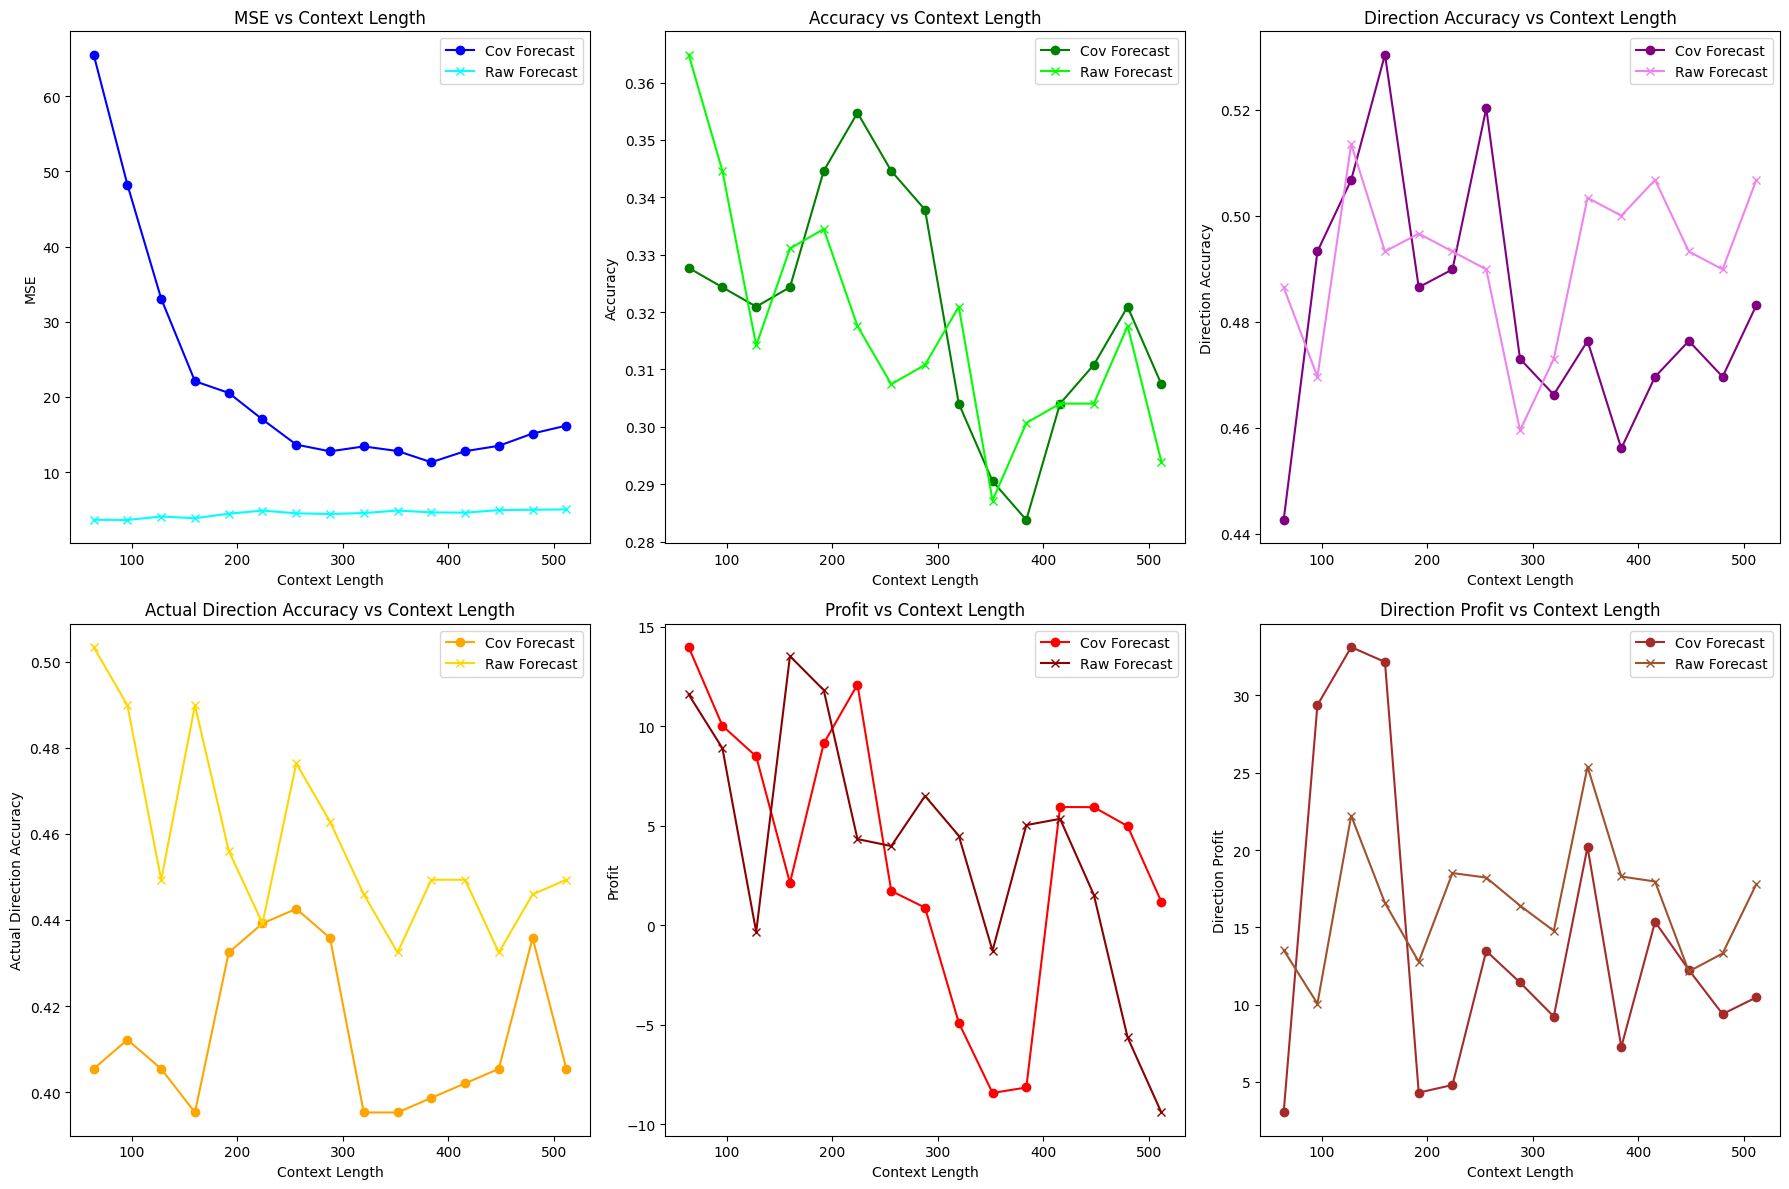

In [34]:
import matplotlib.pyplot as plt

# رسم نمودار تغییرات MSE، Accuracy، Direction Accuracy، Actual Direction Accuracy، Profit و Direction Profit بر حسب context_len
plt.figure(figsize=(18, 12))

# نمودار MSE
plt.subplot(2, 3, 1)
plt.plot(final_results['context_len'], final_results['mse_cov'], marker='o', color='blue', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['mse_raw'], marker='x', color='cyan', label='Raw Forecast')
plt.title('MSE vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('MSE')
plt.legend()

# نمودار Accuracy
plt.subplot(2, 3, 2)
plt.plot(final_results['context_len'], final_results['accuracy_cov'], marker='o', color='green', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['accuracy_raw'], marker='x', color='lime', label='Raw Forecast')
plt.title('Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Accuracy')
plt.legend()

# نمودار Direction Accuracy
plt.subplot(2, 3, 3)
plt.plot(final_results['context_len'], final_results['direction_accuracy_cov'], marker='o', color='purple', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['direction_accuracy_raw'], marker='x', color='violet', label='Raw Forecast')
plt.title('Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Accuracy')
plt.legend()

# نمودار Actual Direction Accuracy
plt.subplot(2, 3, 4)
plt.plot(final_results['context_len'], final_results['actual_direction_accuracy_cov'], marker='o', color='orange', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['actual_direction_accuracy_raw'], marker='x', color='gold', label='Raw Forecast')
plt.title('Actual Direction Accuracy vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Actual Direction Accuracy')
plt.legend()

# نمودار Profit
plt.subplot(2, 3, 5)
plt.plot(final_results['context_len'], final_results['profit_cov'], marker='o', color='red', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['profit_raw'], marker='x', color='darkred', label='Raw Forecast')
plt.title('Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Profit')
plt.legend()

# نمودار Direction Profit
plt.subplot(2, 3, 6)
plt.plot(final_results['context_len'], final_results['direction_profit_cov'], marker='o', color='brown', label='Cov Forecast')
plt.plot(final_results['context_len'], final_results['direction_profit_raw'], marker='x', color='sienna', label='Raw Forecast')
plt.title('Direction Profit vs Context Length')
plt.xlabel('Context Length')
plt.ylabel('Direction Profit')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
# پیدا کردن context_len که بیشترین یا کمترین مقدار هر معیار را دارد برای Cov Forecast

# Minimum MSE برای Cov Forecast
min_mse_cov = final_results.loc[final_results['mse_cov'].idxmin()]
print(f"Minimum MSE (Cov Forecast): {min_mse_cov['mse_cov']} at Context Length: {min_mse_cov['context_len']}")

# Maximum Accuracy برای Cov Forecast
max_accuracy_cov = final_results.loc[final_results['accuracy_cov'].idxmax()]
print(f"Maximum Accuracy (Cov Forecast): {max_accuracy_cov['accuracy_cov']} at Context Length: {max_accuracy_cov['context_len']}")

# Maximum Direction Accuracy برای Cov Forecast
max_direction_accuracy_cov = final_results.loc[final_results['direction_accuracy_cov'].idxmax()]
print(f"Maximum Direction Accuracy (Cov Forecast): {max_direction_accuracy_cov['direction_accuracy_cov']} at Context Length: {max_direction_accuracy_cov['context_len']}")

# Maximum Actual Direction Accuracy برای Cov Forecast
max_actual_direction_accuracy_cov = final_results.loc[final_results['actual_direction_accuracy_cov'].idxmax()]
print(f"Maximum Actual Direction Accuracy (Cov Forecast): {max_actual_direction_accuracy_cov['actual_direction_accuracy_cov']} at Context Length: {max_actual_direction_accuracy_cov['context_len']}")

# Maximum Profit برای Cov Forecast
max_profit_cov = final_results.loc[final_results['profit_cov'].idxmax()]
print(f"Maximum Profit (Cov Forecast): {max_profit_cov['profit_cov']} at Context Length: {max_profit_cov['context_len']}")

# Maximum Direction Profit برای Cov Forecast
max_direction_profit_cov = final_results.loc[final_results['direction_profit_cov'].idxmax()]
print(f"Maximum Direction Profit (Cov Forecast): {max_direction_profit_cov['direction_profit_cov']} at Context Length: {max_direction_profit_cov['context_len']}")


# پیدا کردن context_len که بیشترین یا کمترین مقدار هر معیار را دارد برای Raw Forecast

# Minimum MSE برای Raw Forecast
min_mse_raw = final_results.loc[final_results['mse_raw'].idxmin()]
print(f"Minimum MSE (Raw Forecast): {min_mse_raw['mse_raw']} at Context Length: {min_mse_raw['context_len']}")

# Maximum Accuracy برای Raw Forecast
max_accuracy_raw = final_results.loc[final_results['accuracy_raw'].idxmax()]
print(f"Maximum Accuracy (Raw Forecast): {max_accuracy_raw['accuracy_raw']} at Context Length: {max_accuracy_raw['context_len']}")

# Maximum Direction Accuracy برای Raw Forecast
max_direction_accuracy_raw = final_results.loc[final_results['direction_accuracy_raw'].idxmax()]
print(f"Maximum Direction Accuracy (Raw Forecast): {max_direction_accuracy_raw['direction_accuracy_raw']} at Context Length: {max_direction_accuracy_raw['context_len']}")

# Maximum Actual Direction Accuracy برای Raw Forecast
max_actual_direction_accuracy_raw = final_results.loc[final_results['actual_direction_accuracy_raw'].idxmax()]
print(f"Maximum Actual Direction Accuracy (Raw Forecast): {max_actual_direction_accuracy_raw['actual_direction_accuracy_raw']} at Context Length: {max_actual_direction_accuracy_raw['context_len']}")

# Maximum Profit برای Raw Forecast
max_profit_raw = final_results.loc[final_results['profit_raw'].idxmax()]
print(f"Maximum Profit (Raw Forecast): {max_profit_raw['profit_raw']} at Context Length: {max_profit_raw['context_len']}")

# Maximum Direction Profit برای Raw Forecast
max_direction_profit_raw = final_results.loc[final_results['direction_profit_raw'].idxmax()]
print(f"Maximum Direction Profit (Raw Forecast): {max_direction_profit_raw['direction_profit_raw']} at Context Length: {max_direction_profit_raw['context_len']}")


Minimum MSE (Cov Forecast): 11.321996274860481 at Context Length: 384.0
Maximum Accuracy (Cov Forecast): 0.3547297297297297 at Context Length: 224.0
Maximum Direction Accuracy (Cov Forecast): 0.5304054054054054 at Context Length: 160.0
Maximum Actual Direction Accuracy (Cov Forecast): 0.44256756756756754 at Context Length: 256.0
Maximum Profit (Cov Forecast): 13.96806579007766 at Context Length: 64.0
Maximum Direction Profit (Cov Forecast): 33.13049773705626 at Context Length: 128.0
Minimum MSE (Raw Forecast): 3.6423278235099734 at Context Length: 96.0
Maximum Accuracy (Raw Forecast): 0.36486486486486486 at Context Length: 64.0
Maximum Direction Accuracy (Raw Forecast): 0.5135135135135135 at Context Length: 128.0
Maximum Actual Direction Accuracy (Raw Forecast): 0.5033783783783784 at Context Length: 64.0
Maximum Profit (Raw Forecast): 13.513492005168445 at Context Length: 160.0
Maximum Direction Profit (Raw Forecast): 25.38986251079723 at Context Length: 352.0


In [36]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

25.943615443767555